In [1]:
# basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


In [2]:
import kagglehub

# Download the dataset from Kaggle
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


In [3]:
import pandas as pd

df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Clean Data

In [4]:
# check data types and missing values
df.info()

# totalcharges is stored as object so convert it to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# replace missing totalcharges with 0 (these are mostly new customers with tenure 0)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# quick check
df[['tenure','MonthlyCharges','TotalCharges']].head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Quick Stats

In [5]:
# churn balance
df['Churn'].value_counts(normalize=True)

# average values by churn group
df.groupby('Churn')[['tenure','MonthlyCharges','TotalCharges']].mean().round(2)


,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,37.57,61.27,2549.91
Yes,17.98,74.44,1531.80


In [6]:
# create a binary churn flag
if 'Churn_flag' not in df.columns:
    df['Churn_flag'] = df['Churn'].map({'Yes': 1, 'No': 0})


Exploratory Analysis

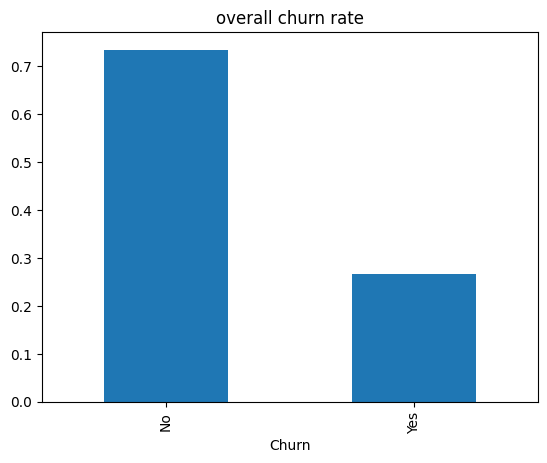

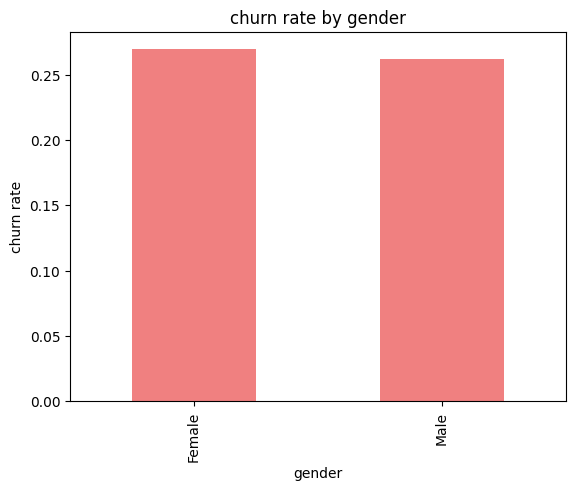

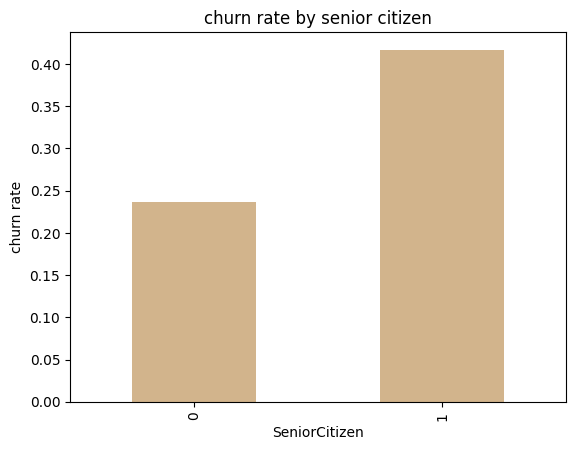

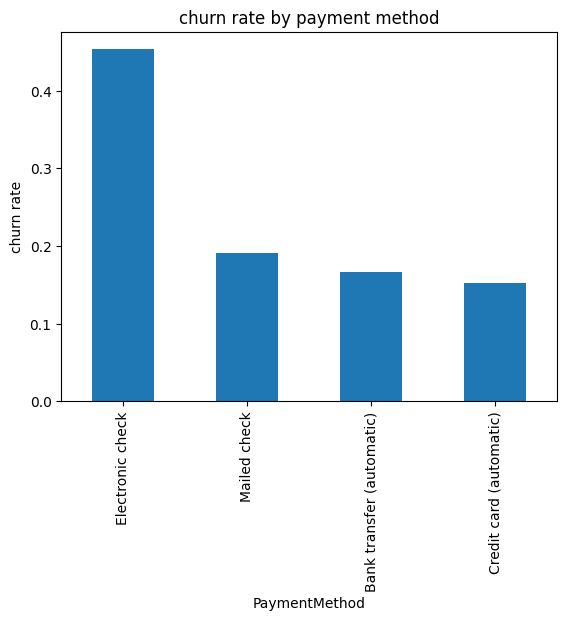

In [7]:
# overall churn rate
df['Churn'].value_counts(normalize=True).plot(kind='bar', title='overall churn rate')
plt.show()

# churn by gender
df.groupby('gender')['Churn_flag'].mean().plot(kind='bar', color='lightcoral')
plt.title('churn rate by gender')
plt.ylabel('churn rate')
plt.show()

# churn by senior citizen
df.groupby('SeniorCitizen')['Churn_flag'].mean().plot(kind='bar', color='tan')
plt.title('churn rate by senior citizen')
plt.ylabel('churn rate')
plt.show()

# churn by payment method
df.groupby('PaymentMethod')['Churn_flag'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('churn rate by payment method')
plt.ylabel('churn rate')
plt.show()


Numeric Relationships

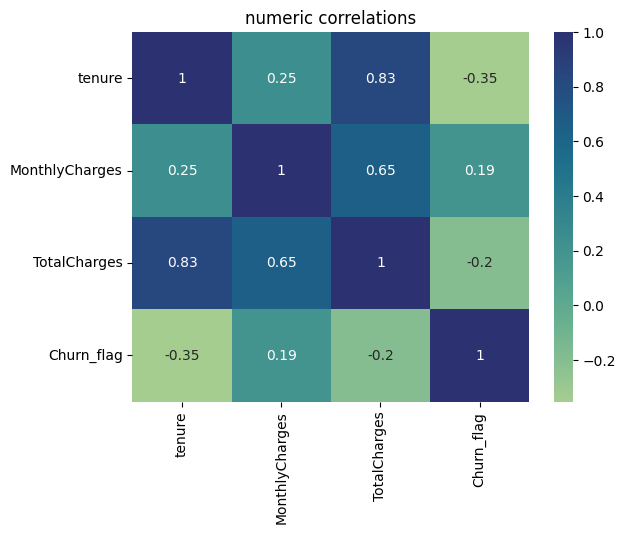

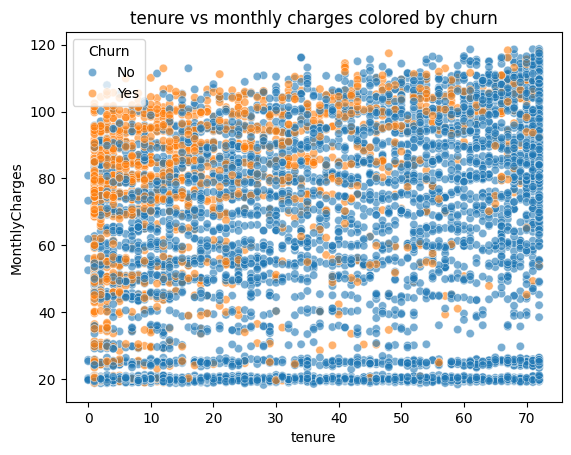

In [8]:
# checking numeric correlations
num_corr = df[['tenure','MonthlyCharges','TotalCharges','Churn_flag']].corr()
num_corr

# visualize correlation heatmap
import seaborn as sns
sns.heatmap(num_corr, annot=True, cmap='crest')
plt.title('numeric correlations')
plt.show()

# scatter of tenure vs monthly charges, color by churn
sns.scatterplot(data=df, x='tenure', y='MonthlyCharges', hue='Churn', alpha=0.6)
plt.title('tenure vs monthly charges colored by churn')
plt.show()


Customer Behavior Patterns

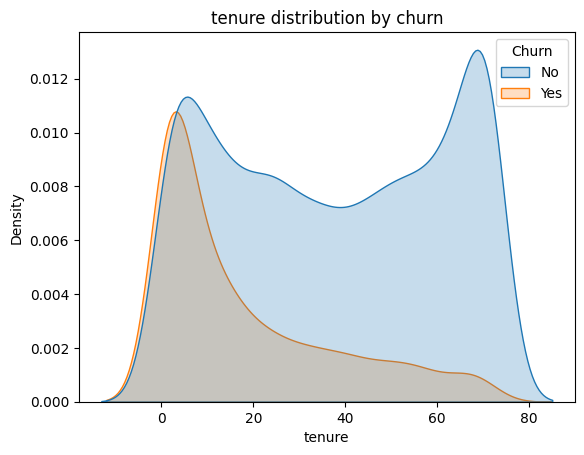

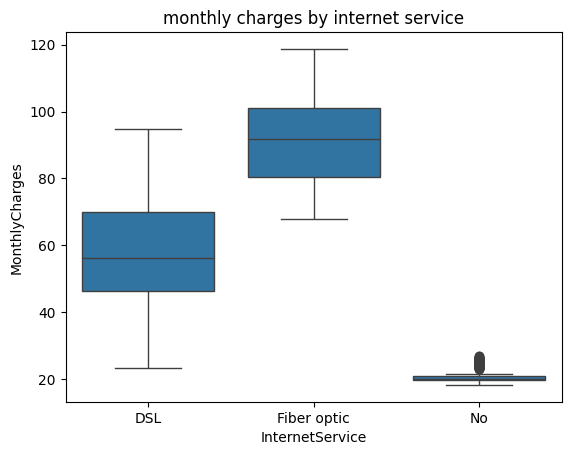

In [9]:
# average tenure and charges by contract type
df.groupby('Contract')[['tenure','MonthlyCharges','TotalCharges']].mean().round(1)

# churn rates by contract and internet service type
pd.crosstab(df['Contract'], df['InternetService'], values=df['Churn_flag'], aggfunc='mean').round(2)

# tenure distribution by churn
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True)
plt.title('tenure distribution by churn')
plt.show()

# monthly charges by internet service
sns.boxplot(data=df, x='InternetService', y='MonthlyCharges')
plt.title('monthly charges by internet service')
plt.show()


Deeper Churn Patterns

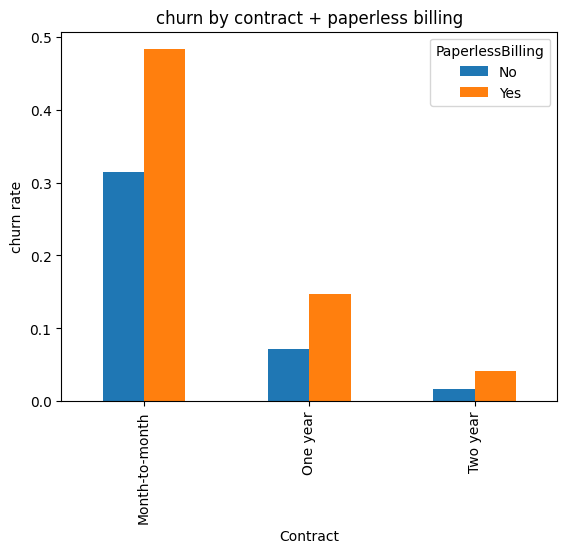

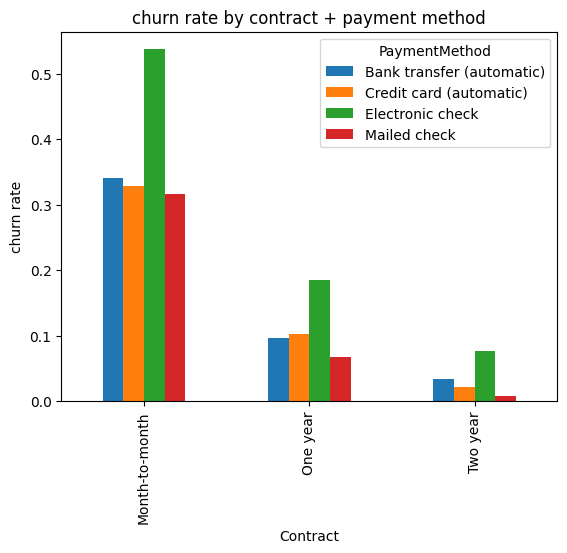

In [10]:
# churn rate by contract + paperless billing
df.groupby(['Contract','PaperlessBilling'])['Churn_flag'].mean().unstack().plot(kind='bar')
plt.title('churn by contract + paperless billing')
plt.ylabel('churn rate')
plt.show()

# churn rate by contract + payment method
pd.crosstab(df['Contract'], df['PaymentMethod'], values=df['Churn_flag'], aggfunc='mean').plot(kind='bar')
plt.title('churn rate by contract + payment method')
plt.ylabel('churn rate')
plt.show()


Customer Lifetime Value and Tenure Bins

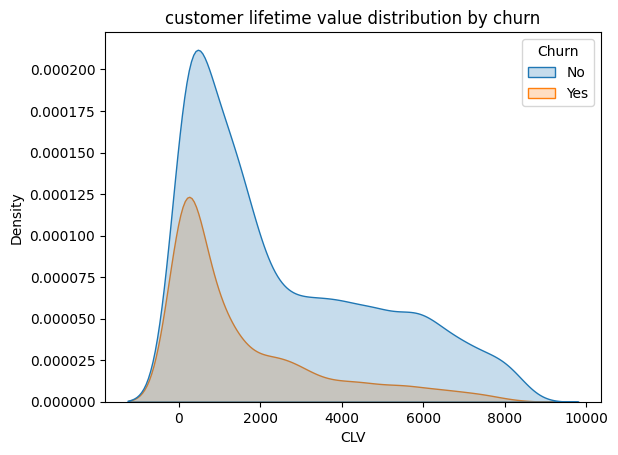

/tmp/ipython-input-3449975730.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('TenureGroup')['Churn_flag'].mean().plot(kind='bar')


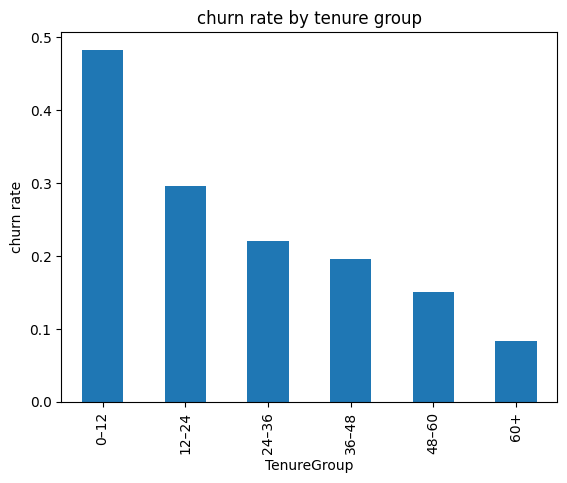

In [11]:
# create simple CLV estimate
df['CLV'] = df['MonthlyCharges'] * df['tenure']

# compare clv between churned and retained
df.groupby('Churn')['CLV'].mean().round(2)

# visualize clv distribution
sns.kdeplot(data=df, x='CLV', hue='Churn', fill=True)
plt.title('customer lifetime value distribution by churn')
plt.show()

# group tenure into bins to visualize retention trend
bins = [0, 12, 24, 36, 48, 60, 72]
labels = ['0–12','12–24','24–36','36–48','48–60','60+']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)
df.groupby('TenureGroup')['Churn_flag'].mean().plot(kind='bar')
plt.title('churn rate by tenure group')
plt.ylabel('churn rate')
plt.show()


Visuals

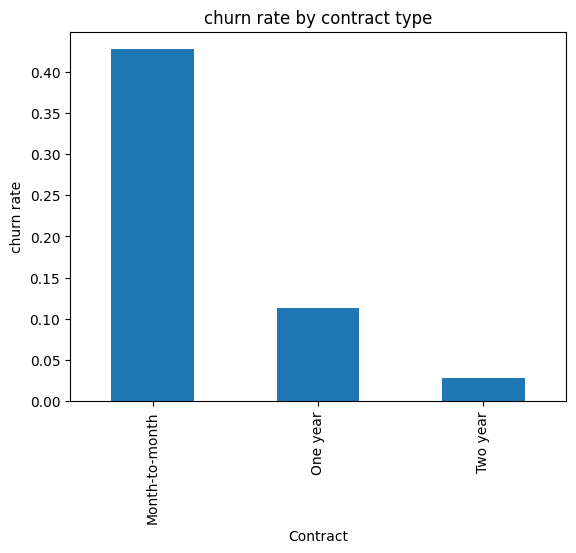

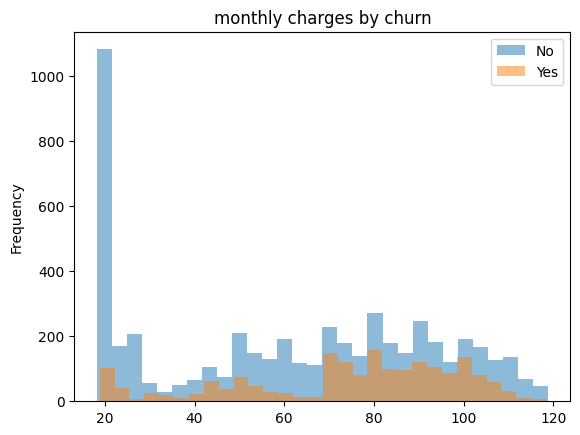

In [12]:
# churn rate by contract
df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack()['Yes'].plot(kind='bar')
plt.title('churn rate by contract type')
plt.ylabel('churn rate')
plt.show()

# distribution of monthly charges by churn
for label, subset in df.groupby('Churn'):
    subset['MonthlyCharges'].plot(kind='hist', bins=30, alpha=0.5, label=label)
plt.title('monthly charges by churn')
plt.legend()
plt.show()


Mini KPIs

In [13]:
# simple summary KPIs to reference later
summary = {
    'overall_churn_rate': round(df['Churn_flag'].mean()*100, 1),
    'avg_tenure_churned': round(df[df['Churn_flag']==1]['tenure'].mean(), 1),
    'avg_tenure_retained': round(df[df['Churn_flag']==0]['tenure'].mean(), 1),
    'avg_monthly_charges_churned': round(df[df['Churn_flag']==1]['MonthlyCharges'].mean(), 1),
    'avg_monthly_charges_retained': round(df[df['Churn_flag']==0]['MonthlyCharges'].mean(), 1)
}

print("mini kpi summary")
print(f"overall churn rate: {summary['overall_churn_rate']}%")
print(f"avg tenure (churned): {summary['avg_tenure_churned']} months")
print(f"avg tenure (retained): {summary['avg_tenure_retained']} months")
print(f"avg monthly charges (churned): ${summary['avg_monthly_charges_churned']}")
print(f"avg monthly charges (retained): ${summary['avg_monthly_charges_retained']}")



mini kpi summary
overall churn rate: 26.5%
avg tenure (churned): 18.0 months
avg tenure (retained): 37.6 months
avg monthly charges (churned): $74.4
avg monthly charges (retained): $61.3


Findings Summary

In [14]:
# summarize key findings from EDA and KPIs

print("customer churn analysis summary\n")

print(f"- overall churn rate: {summary['overall_churn_rate']}% of customers.")
print(f"- churned customers have an average tenure of {summary['avg_tenure_churned']} months, "
      f"while retained customers average {summary['avg_tenure_retained']} months.")
print(f"- churned customers pay about ${summary['avg_monthly_charges_churned']} per month on average, "
      f"vs ${summary['avg_monthly_charges_retained']} for retained ones.\n")

print("main behavioral insights:")
print("- month-to-month contracts have the highest churn rates by far; longer-term contracts are much more stable.")
print("- churn likelihood increases when customers have higher monthly charges but shorter tenure.")
print("- fiber optic users and those paying via electronic check show higher churn tendencies.")
print("- paperless billing combined with month-to-month contracts is another strong churn pattern.\n")

print("business takeaways:")
print("- early tenure (first ~12 months) is the riskiest window — invest in onboarding and loyalty programs.")
print("- offering contract extensions or small discounts could retain high-charge customers.")
print("- focus retention outreach on customers paying electronically or without bundled services.")


customer churn analysis summary

- overall churn rate: 26.5% of customers.
- churned customers have an average tenure of 18.0 months, while retained customers average 37.6 months.
- churned customers pay about $74.4 per month on average, vs $61.3 for retained ones.

main behavioral insights:
- month-to-month contracts have the highest churn rates by far; longer-term contracts are much more stable.
- churn likelihood increases when customers have higher monthly charges but shorter tenure.
- fiber optic users and those paying via electronic check show higher churn tendencies.
- paperless billing combined with month-to-month contracts is another strong churn pattern.

business takeaways:
- early tenure (first ~12 months) is the riskiest window — invest in onboarding and loyalty programs.
- offering contract extensions or small discounts could retain high-charge customers.
- focus retention outreach on customers paying electronically or without bundled services.


Prep Data for Modeling

In [15]:
# convert churn to 0/1
df['Churn_flag'] = df['Churn'].map({'Yes':1,'No':0})

# pick columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [col for col in df.select_dtypes('object') if col not in ['customerID','Churn']]

# split train/test
X = df[cat_cols + num_cols]
y = df['Churn_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Logistic Regression

In [16]:
# preprocess: onehot encode cats, scale nums
preprocess = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# logistic regression model
logreg = Pipeline([
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=300, random_state=42))
])

logreg.fit(X_train, y_train)
preds_lr = logreg.predict(X_test)
probs_lr = logreg.predict_proba(X_test)[:,1]

print("logistic regression results:")
print(classification_report(y_test, preds_lr))
print("roc-auc:", round(roc_auc_score(y_test, probs_lr),3))


logistic regression results:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409

roc-auc: 0.841


Random Forest

In [17]:
rf = Pipeline([
    ('prep', preprocess),
    ('model', RandomForestClassifier(n_estimators=300, random_state=42))
])

rf.fit(X_train, y_train)
preds_rf = rf.predict(X_test)
probs_rf = rf.predict_proba(X_test)[:,1]

print("random forest results:")
print(classification_report(y_test, preds_rf))
print("roc-auc:", round(roc_auc_score(y_test, probs_rf),3))


random forest results:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.78      1409

roc-auc: 0.822


Confusion Matrix

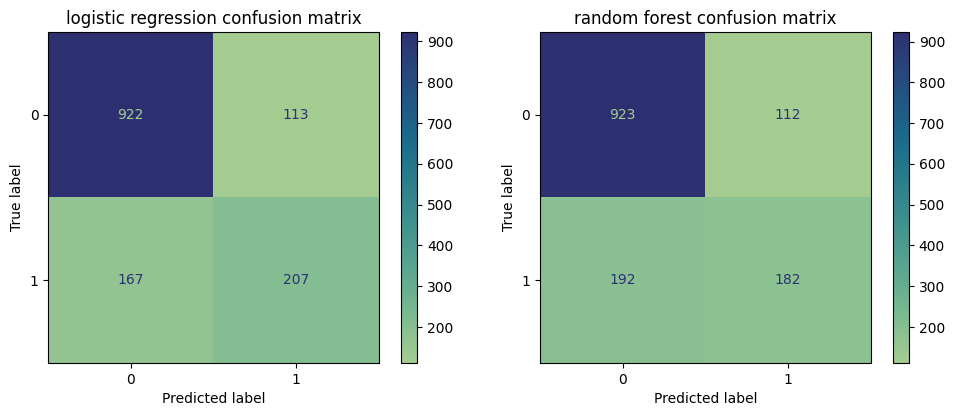

In [18]:
# visualize confusion matrices to compare models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, preds_lr, ax=ax[0], cmap='crest')
ax[0].set_title('logistic regression confusion matrix')

ConfusionMatrixDisplay.from_predictions(y_test, preds_rf, ax=ax[1], cmap='crest')
ax[1].set_title('random forest confusion matrix')
plt.tight_layout()
plt.show()


ROC Curve Comparison

<Figure size 600x500 with 0 Axes>

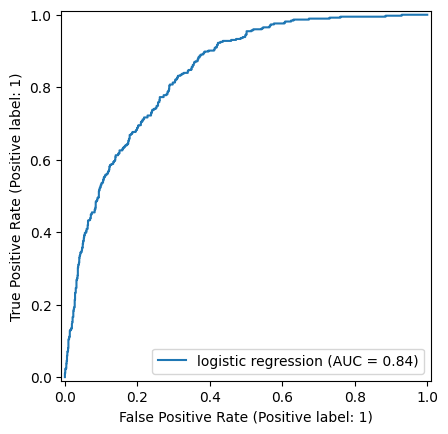

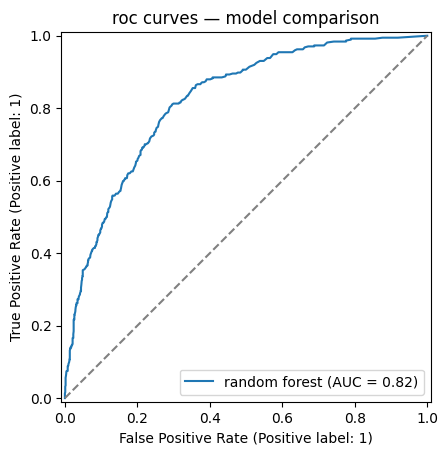

In [19]:
# compare both models on the same ROC plot
from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, probs_lr, name='logistic regression')
RocCurveDisplay.from_predictions(y_test, probs_rf, name='random forest')
plt.plot([0,1],[0,1],'--', color='gray')
plt.title('roc curves — model comparison')
plt.show()


Preciision Recall Curve

<Figure size 600x500 with 0 Axes>

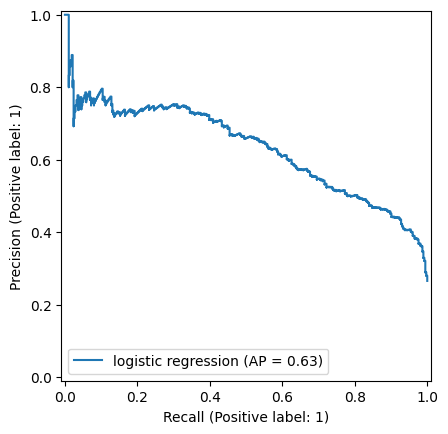

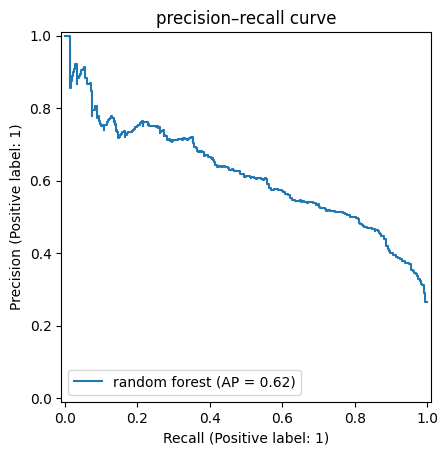

In [20]:
# plot precision vs recall curves
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, probs_lr, name='logistic regression')
PrecisionRecallDisplay.from_predictions(y_test, probs_rf, name='random forest')
plt.title('precision–recall curve')
plt.show()


Feature Importance

In [25]:
# get feature names from the preprocessing step in the pipeline
ohe = rf.named_steps['prep'].named_transformers_['cat']
encoded = list(ohe.get_feature_names_out(cat_cols))
features = encoded + num_cols

# get feature importances from the trained random forest
importances = rf.named_steps['model'].feature_importances_


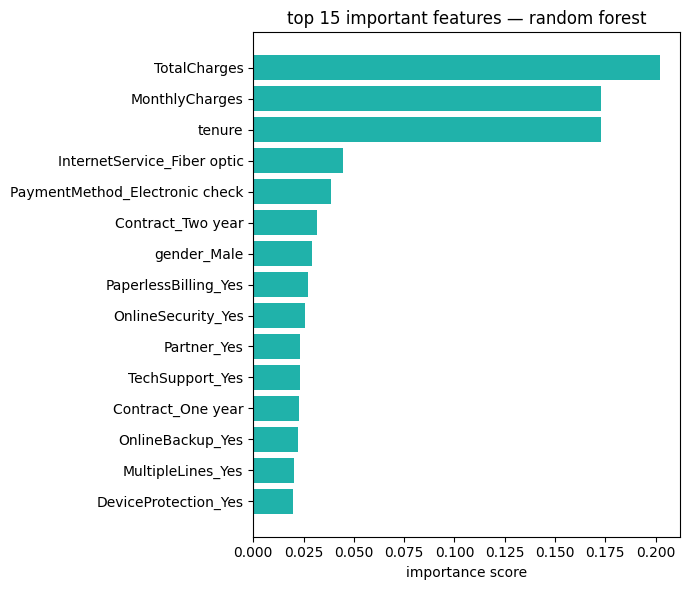

In [26]:

fi = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=True).tail(15)

plt.figure(figsize=(7,6))
plt.barh(fi['feature'], fi['importance'], color='lightseagreen')
plt.title('top 15 important features — random forest')
plt.xlabel('importance score')
plt.tight_layout()
plt.show()



Model Comparison Summary

In [23]:
# create a quick comparison table
metrics = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'ROC-AUC': [roc_auc_score(y_test, probs_lr), roc_auc_score(y_test, probs_rf)],
    'Accuracy': [logreg.score(X_test, y_test), rf.score(X_test, y_test)],
    'Precision': [classification_report(y_test, preds_lr, output_dict=True)['1']['precision'],
                  classification_report(y_test, preds_rf, output_dict=True)['1']['precision']],
    'Recall': [classification_report(y_test, preds_lr, output_dict=True)['1']['recall'],
               classification_report(y_test, preds_rf, output_dict=True)['1']['recall']]
}).round(3)

metrics



,Model,ROC-AUC,Accuracy,Precision,Recall
0,Logistic Regression,0.841,0.801,0.647,0.553
1,Random Forest,0.822,0.784,0.619,0.487


In [28]:
print("final project summary\n")

print("project goal:")
print("- analyze telco customer data to understand what drives churn and build predictive models to flag high-risk customers.\n")

print("key insights from analysis:")
print("- overall churn rate ≈ 26%.")
print("- month-to-month contracts churn the most; longer-term contracts are more stable.")
print("- churners have higher monthly charges and shorter tenure on average.\n")

print("modeling results:")
print("- logistic regression outperformed random forest in my run (higher roc-auc and accuracy).")
print("- top drivers in the tree-based model were TotalCharges, MonthlyCharges, tenure, fiber optic internet, electronic check payments, longer contracts, and paperless billing.")
print("- note: TotalCharges is a composite that overlaps with tenure × monthly charges; for actionability I also evaluate models without TotalCharges.\n")

print("business recommendations:")
print("- focus retention on month-to-month customers early in the lifecycle (tenure < ~12 months).")
print("- offer plan reviews or discounts for high-charge customers to reduce price-related churn.")
print("- review experiences for fiber optic users and electronic-check payers (both higher-risk groups).")
print("- deploy the logistic regression model in dashboards for interpretable, stable scoring.\n")

print("overall takeaway:")
print("simple EDA + interpretable modeling surfaces clear levers (contract, tenure, price) and a targeting list for outreach.")



final project summary

project goal:
- analyze telco customer data to understand what drives churn and build predictive models to flag high-risk customers.

key insights from analysis:
- overall churn rate ≈ 26%.
- month-to-month contracts churn the most; longer-term contracts are more stable.
- churners have higher monthly charges and shorter tenure on average.

modeling results:
- logistic regression outperformed random forest in my run (higher roc-auc and accuracy).
- top drivers in the tree-based model were TotalCharges, MonthlyCharges, tenure, fiber optic internet, electronic check payments, longer contracts, and paperless billing.
- note: TotalCharges is a composite that overlaps with tenure × monthly charges; for actionability I also evaluate models without TotalCharges.

business recommendations:
- focus retention on month-to-month customers early in the lifecycle (tenure < ~12 months).
- offer plan reviews or discounts for high-charge customers to reduce price-related churn.
-